Import the libraries

In [21]:
import numpy as np
import pandas as pd
from sklearn.linear_model import SGDRegressor
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import learning_curve, cross_val_score

Set the seeds

In [22]:
seed = 2377
np.random.seed(seed)
random.seed(seed)

Read the data

In [23]:
df = pd.read_csv("Valhalla23.csv")
x = df["Celsius"]
y = df["Valks"]
df

,Celsius,Valks
0,61.4720,-139.7400
1,70.5790,-156.6000
2,-7.3013,73.2690
3,71.3380,-165.4200
4,43.2360,-75.8350
...,...,...
95,-7.0094,69.6320
96,36.8820,-71.2400
97,26.9390,-34.2550
98,-18.8100,106.4300


Split the data: training (40%), validation (40%), and test (20%) sets

In [24]:
train = df.sample(frac=0.8, random_state=seed)

df = df.drop(train.index)
test = df

validation = train.sample(frac=0.5, random_state=seed)
train = train.drop(validation.index)

len(train), len(validation), len(test)

(40, 40, 20)

In [25]:
learning_rate = 1e-4

model = SGDRegressor(
    max_iter=1_000_000, 
    learning_rate='constant',
    eta0=learning_rate,
    random_state=seed
)

X_train = train.drop(columns=["Valks"])
y_train = train["Valks"]

X_validation = validation.drop(columns=["Valks"])
y_validation = validation["Valks"]

X_test = test.drop(columns=["Valks"])
y_test = test["Valks"]

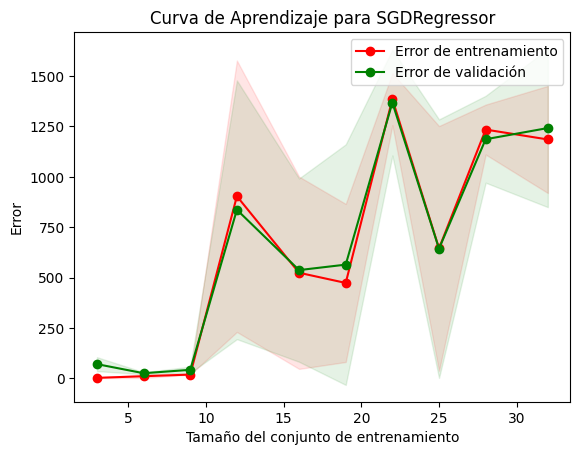

Error de validación cruzada (MSE): 1242.342 +/- 392.501


In [26]:
# Curva de aprendizaje
train_sizes, train_scores, val_scores = learning_curve(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error', train_sizes=np.linspace(0.1, 1.0, 10))

# Calcular el promedio y la desviación estándar
train_mean = -np.mean(train_scores, axis=1)
val_mean = -np.mean(val_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Graficar la curva de aprendizaje
plt.plot(train_sizes, train_mean, 'o-', color="r", label="Error de entrenamiento")
plt.plot(train_sizes, val_mean, 'o-', color="g", label="Error de validación")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color="g")

plt.title('Curva de Aprendizaje para SGDRegressor')
plt.xlabel('Tamaño del conjunto de entrenamiento')
plt.ylabel('Error')
plt.legend(loc="best")
plt.show()

# Validación cruzada
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print(f'Error de validación cruzada (MSE): {-cv_scores.mean():.3f} +/- {cv_scores.std():.3f}')

Podemos observar un grado considerable de sesgo.

Caculate the mse for each set of data

In [27]:
model.fit(X_train, y_train)

mse_train = np.mean((model.predict(X_train) - y_train) ** 2)

mse_validation = np.mean((model.predict(X_validation) - y_validation) ** 2)

mse_test = np.mean((model.predict(X_test) - y_test) ** 2)

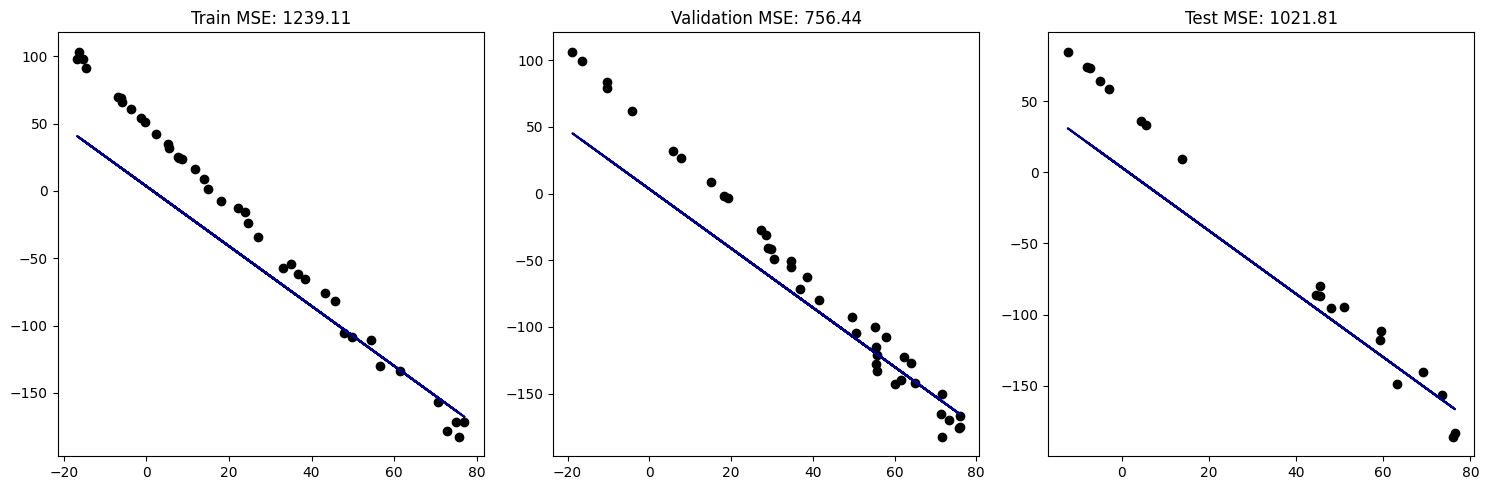

In [28]:
# Create subplots: 1 row, 3 columns
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Train subplot
axs[0].scatter(X_train, y_train, color="black", label="Train")
axs[0].plot(X_train, model.predict(X_train), color="navy", label="Model")
axs[0].set_title(f"Train MSE: {mse_train:.2f}")

# Validation subplot
axs[1].scatter(X_validation, y_validation, color="black", label="Validation")
axs[1].plot(X_validation, model.predict(X_validation), color="navy", label="Model")
axs[1].set_title(f"Validation MSE: {mse_validation:.2f}")


# Test subplot
axs[2].scatter(X_test, y_test, color="black", label="Test")
axs[2].plot(X_test, model.predict(X_test), color="navy", label="Model")
axs[2].set_title(f"Test MSE: {mse_test:.2f}")

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

Create a list with numbers between 2 and 40

In [29]:
numbers = list(range(2, 40))

# Make sure the number 2 is in the list 
final_list = [2]
numbers.remove(2)

final_list += random.sample(numbers, 19)

In [30]:
final_list, len(final_list)

([2, 32, 24, 23, 8, 11, 36, 29, 30, 13, 19, 25, 9, 7, 21, 4, 26, 22, 17, 6],
 20)

In [31]:
dict_of_models = {}
number_models = 100

for i in final_list:

    models = []

    for model_i in range(number_models):

        # get a subset of the data from train with the amount of values of i
        train_subset = train.sample(i, random_state=seed)

        X_train_subset = train_subset.drop(columns=["Valks"])
        y_train_subset = train_subset["Valks"]

        model = SGDRegressor(
            max_iter=1_000_000, 
            learning_rate='constant',
            eta0=learning_rate,
        )

        model.fit(X_train, y_train)

        # Calculate the MSE for the train subset
        mse_train = np.mean((model.predict(X_train_subset) - y_train_subset) ** 2)

        # Calculate the MSE for the validation data
        mse_validation = np.mean((model.predict(X_validation) - y_validation) ** 2)

        # create a tuple with the model and the mse
        models.append((model, mse_train, mse_validation))

    dict_of_models[i] = models

In [32]:
# verify the length of the dictionary and the length of the models
len(dict_of_models), len(dict_of_models[2])

(20, 100)

In [33]:
# calculate the mean of the mse (train and validation) for each model
mean_mse = {}

for i in dict_of_models:
    mean_mse[i] = (
        np.mean([model[1] for model in dict_of_models[i]]),
        np.mean([model[2] for model in dict_of_models[i]])
    )

mean_mse # (train mse, validation mse)

{2: (952.6308962791061, 682.6383632930281),
 32: (1061.069290800353, 663.9462800688453),
 24: (944.2521791746015, 658.4850621604311),
 23: (938.6499492302502, 674.4428513447735),
 8: (989.8553832415412, 670.3631150015405),
 11: (905.5652042596297, 632.7420098096321),
 36: (966.7077881822895, 635.5431897315545),
 29: (995.6851455708608, 620.3944372325577),
 30: (1054.2714429732255, 662.209184891686),
 13: (914.1369454402145, 623.9393140097679),
 19: (949.3150822963935, 639.5769253416728),
 25: (959.782982951397, 638.5654907734894),
 9: (856.1029843279877, 647.4112306529497),
 7: (1001.5294963074614, 622.9554009240298),
 21: (868.1717973994014, 638.8877486287344),
 4: (843.7353098521007, 658.36737886336),
 26: (947.8543847967858, 635.5150733617105),
 22: (886.1824792263442, 637.3848570644147),
 17: (895.8928849812838, 662.5266081245579),
 6: (1165.143360530994, 653.6753034252697)}

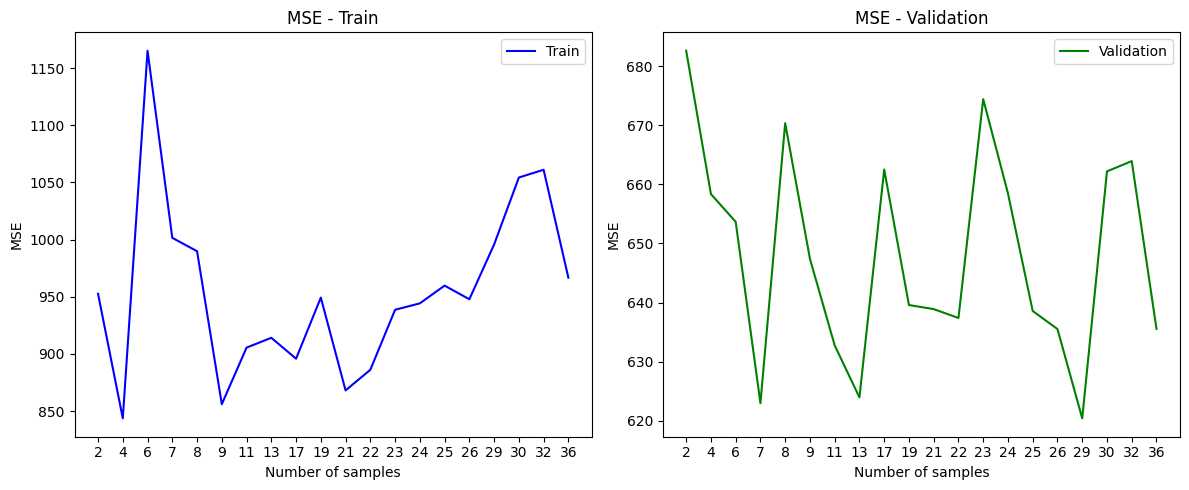

In [34]:
# Sort the keys of mean_mse
sorted_keys = sorted(mean_mse.keys())

# Extract MSE values for train and validation in the order of sorted keys
mse_train = [mean_mse[i][0] for i in sorted_keys]
mse_validation = [mean_mse[i][1] for i in sorted_keys]

# Create subplots: 1 row, 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot mse_train on the first subplot
ax1.plot(mse_train, label="Train", color='blue')
ax1.set_xlabel("Number of samples")
ax1.set_ylabel("MSE")
ax1.set_title("MSE - Train")
ax1.set_xticks(range(len(mse_train)))
ax1.set_xticklabels(sorted_keys)
ax1.legend()

# Plot mse_validation on the second subplot
ax2.plot(mse_validation, label="Validation", color='green')
ax2.set_xlabel("Number of samples")
ax2.set_ylabel("MSE")
ax2.set_title("MSE - Validation")
ax2.set_xticks(range(len(mse_validation)))
ax2.set_xticklabels(sorted_keys)
ax2.legend()

# Adjust layout for better display
plt.tight_layout()
plt.show()

Model Adjustment
- 2 samples: Not bad MSE in the training set but way worse in the validation set because it practially learned nothing.
- 36 samples: Seems to be at an equilibrium point. The model is not overfitting or underfitting. And also, the both training and validation MSE have the same movement.

How the adjustment change as the sample size increases?
- The ideal size for achieving the best results is the train MSE is 4, 9 or 21 samples. But this is not ideal for the validation set because the model migth now generalize well.
- The ideal size for achieving the best results is the validation MSE is 29 samples. This is way better because the model can generalize well and predict better unseen data.

What is the best size for the model trainig?
- Around 29 samples. As explained before, this is the best size for the validation set and the model can generalize well.

Bias and variance:

- Model with 2 samples: Low bias and high variance due to the overfitting. Basically a good fit for the training set but not for the validation set.
- Model with 40 samples: Seems to be in a good equilibrium point. The model is not overfitting or underfitting. And also, the both training and validation MSE have the same movement.

We can see the improvement in the model in terms of the equilibrium between bias and variance as the sample size increases.

For other models: 
- Models with 4 and 9 samples: both have low bias and high variance. The model is overfitting and not generalizing well. There is a high difference between the training and validation MSE.
- Model with 7 samples: low variance and high bias. The model is underfitting and not generalizing well

Train the model with the new sample size

In [35]:
df = pd.read_csv("Valhalla23.csv")
x = df["Celsius"]
y = df["Valks"]

In [36]:
train = df.sample(frac=0.8, random_state=seed)

df = df.drop(train.index)
test = df

validation = train.sample(frac=0.5, random_state=seed)
train = train.drop(validation.index)

len(train), len(validation), len(test)

(40, 40, 20)

In [37]:
# just use 29 samples for the training
train = train.sample(29, random_state=seed)

In [38]:
learning_rate = 1e-4

model = SGDRegressor(
    max_iter=1_000_000, 
    learning_rate='constant',
    eta0=learning_rate,
    random_state=seed
)

X_train = train.drop(columns=["Valks"])
y_train = train["Valks"]

X_validation = validation.drop(columns=["Valks"])
y_validation = validation["Valks"]

X_test = test.drop(columns=["Valks"])
y_test = test["Valks"]

In [39]:
model.fit(X_train, y_train)

mse_train = np.mean((model.predict(X_train) - y_train) ** 2)

mse_validation = np.mean((model.predict(X_validation) - y_validation) ** 2)

mse_test = np.mean((model.predict(X_test) - y_test) ** 2)

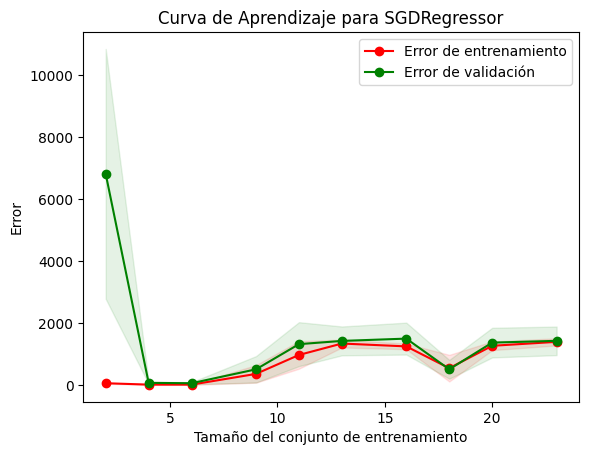

Error de validación cruzada (MSE): 1425.647 +/- 459.991


In [40]:
# Curva de aprendizaje
train_sizes, train_scores, val_scores = learning_curve(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error', train_sizes=np.linspace(0.1, 1.0, 10))

# Calcular el promedio y la desviación estándar
train_mean = -np.mean(train_scores, axis=1)
val_mean = -np.mean(val_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Graficar la curva de aprendizaje
plt.plot(train_sizes, train_mean, 'o-', color="r", label="Error de entrenamiento")
plt.plot(train_sizes, val_mean, 'o-', color="g", label="Error de validación")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color="g")

plt.title('Curva de Aprendizaje para SGDRegressor')
plt.xlabel('Tamaño del conjunto de entrenamiento')
plt.ylabel('Error')
plt.legend(loc="best")
plt.show()

# Validación cruzada
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print(f'Error de validación cruzada (MSE): {-cv_scores.mean():.3f} +/- {cv_scores.std():.3f}')

Results for the new model with 29 samples

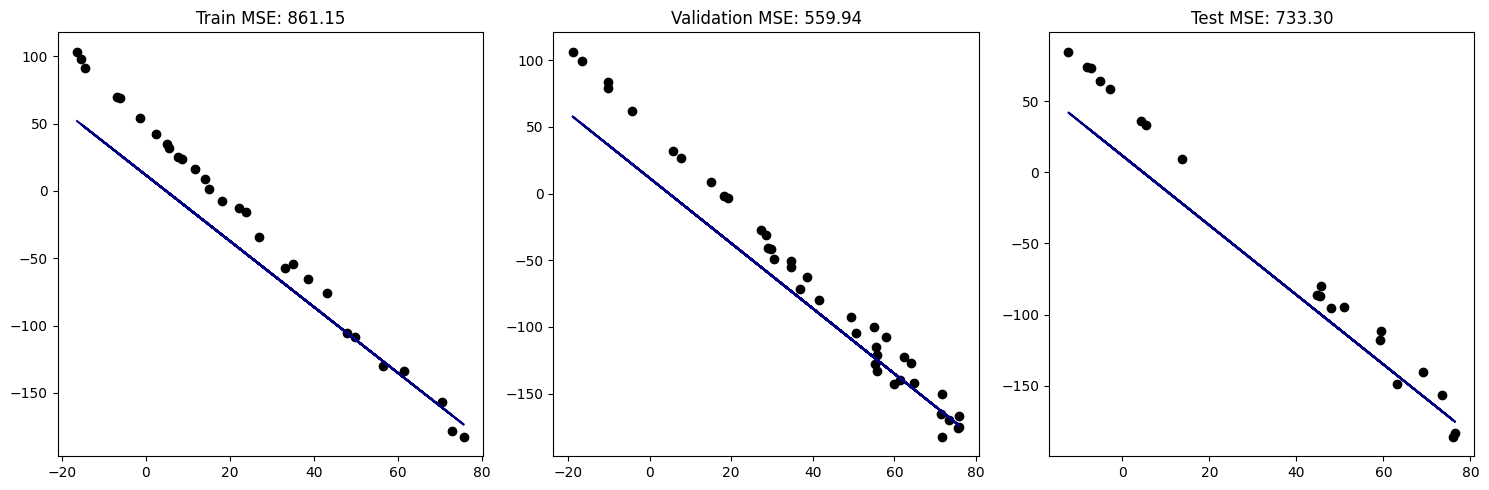

In [41]:
# Create subplots: 1 row, 3 columns
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Train subplot
axs[0].scatter(X_train, y_train, color="black", label="Train")
axs[0].plot(X_train, model.predict(X_train), color="navy", label="Model")
axs[0].set_title(f"Train MSE: {mse_train:.2f}")

# Validation subplot
axs[1].scatter(X_validation, y_validation, color="black", label="Validation")
axs[1].plot(X_validation, model.predict(X_validation), color="navy", label="Model")
axs[1].set_title(f"Validation MSE: {mse_validation:.2f}")


# Test subplot
axs[2].scatter(X_test, y_test, color="black", label="Test")
axs[2].plot(X_test, model.predict(X_test), color="navy", label="Model")
axs[2].set_title(f"Test MSE: {mse_test:.2f}")

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

Results of the base model

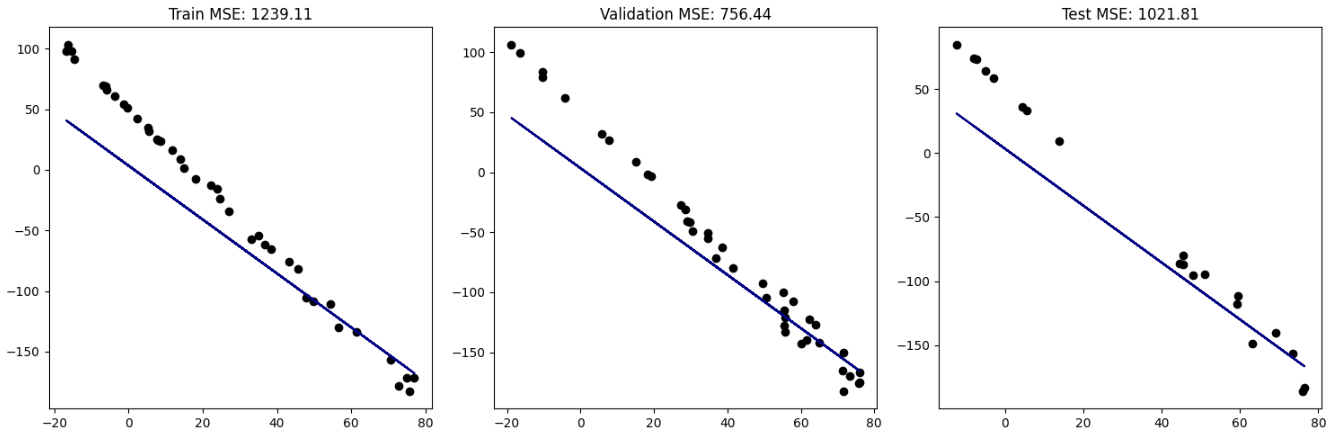

Comparison

As you can see, the new model with 29 samples is way better.
The new model:
- Has a lower MSE for the training set.
- Has a lower MSE for the validation set.
- Has a lower MSE for the test set.

As we expected, the model with 29 samples improved the results because now the model can generalize way better.